# Methodology


I'll describe the model's architecture, from beginning to end.

What we're looking for is an image hashing function for retrieving similar images. The model should take in an image, and spit something out the other end. That thing, when interpreted as a point in n-dimensional space, should be close to other images like it, but far away from ones that aren't.

This model is a convolutional neural network, utilizing self-supervised transfer learning. I'll step through what this means.

I've chosen my domain of choice to be digital illustrations. An algorithm called "phash"(1) has already proven to be incredibly effective at solving the near-duplicate image retrieval problem in hamming space for real pictures. However, the algorithm since it utilizes a discrete cosine transform, the same technique used in lossy jpg compression, suffers some of the same downsides. Since cosine waves are continous, they are not the greatest at finding the principal components images with hard lines, usually resulting in a noisier image on the other end. In the domain of real life pictures this is less of a problem. With bitmap images it is more so.

We begin with one dataset full of digital illustrations, downloaded from the anime artwork website Safebooru. These are resized to 32x32, and stored to disk in a "Train" folder. I've already written a Java program that does this. Source code will be linked. As it is being trained on anime illustrations, the model may only be particulary useful at generating hashes of anime illustrations. But it can be retrained with the dataset of your choice. 

The full model will take in an image, and immediately the architecture has a branch. The original image is passed to multiple other layers which mess the image up in various ways. One downfall of phash, and in fact many perceptual image hashing algorithms is that they are not invariant to flips or rotation.(2) Whereas a human can look at two images and tell that they are duplicates if they are rotated, it is a much more difficult task in the realm of perceptual image hashing, unless you want to compute a lot more hashes on flipped and rotated images that take up a lot of extra time to compute and space to store, or otherwise use a hash that is not very robust to noise. With a machine learning approach, flips and rotations are much easier to account for. Just train on flipped and rotated images.

Each of the scrombled images, plus the original, is fed into a convolutional neural network which compresses the image down smaller and smaller with convolutional and max pooling layers. At the end they are fed into a densely connected network, which produces what we're looking for, the latent space of the images. The hash that we're looking for. All that's left to do is to try and reconstruct the image and compute loss. 

So, I said earlier that the aim of the whole ordeal is to create a hash of the image which is close to similar images in n-dimensional space. It makes sense that we would train on that. The scrombled images are all similar. Therefore we want to have all of them cross-compare to each other, with as little loss as possible. 

But there's a problem. If that's all we train on, and all the network ever sees is at one time are images that are the same, eventually all the hashes may start coming out the same too. We are not incentivising perceptually distant images to have distant hash vectors. A potential solution is that I could just choose some number as a distance between hashes that aren't the same. But, who am I to choose that? Isn't machine learning here for the purpose of not having to make those decisions? Instead, let's train on another metric alongside n-dimensional distance. Let's train on reconstruction as well.

We can pass the original image through that decoder that I mentioned, and also train on how well the image can be decoded. This way, the vector coming from the autodecoder must also be in some sense a faithful representation of the image. By making the decoder need to be able to "know what the original looked like," we can make the encoder preserve that notion. 

Additionally, this method has actually been used to some success in the past for the purposes of retrieving similar images.(3) Just the act of compression in an autoencoder performing principle component analysis on the contents of an image makes images that are similar produce similar vectors. However, my approach varies from those that have been taken in the past.

Earlier, I called my approach self-supervised transfer learning. But I haven't said what that means. Self-supervised is a term that came about because it isn't "unsupervised", at least not in the traditional sense of the literature, but we also aren't telling the model what the latent space should look like. We're imposing a set of criteria, but we aren't providing it examples or otherwise telling it how to do its job. Hence we are not supervising it. 

The approach utilizes transfer learning because I don't actually evaluate the whole thing all at once. First I train a really good autoencoder, and then I make modifications. The autoencoder distills the essence of the information, and then we tweak it so that it lines up. 

Finally, we can remove the decoder, all the brances, and the scrombling layer, we'll have a usable encoder for image hashing. Or we won't. Let's find out together.

### References:

1) [phash.org](phash.org)

2) [phash Thesis](https://www.phash.org/docs/pubs/thesis_zauner.pdf) (Provides a great overview of percepual image hashing)

3) [Autoencoder Image Retrieval](https://github.com/ankonzoid/artificio/tree/master/image_retrieval)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
from PIL import Image
from urllib.request import urlopen
from io import BytesIO
from IPython.core.display import display, HTML
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Flatten, Reshape
from keras.layers import GaussianNoise
from keras.utils import plot_model
from keras.losses import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras import backend as K

Using TensorFlow backend.


# Hyperparameters

In [2]:
side_length = 32
i_shape = (side_length, side_length, 3)
latent_shape = (None, 20)

convlayers = 2
denselayers = 3

distance_weight = 1
mse_weight = 1

batch_size = 32
epoch_num = 500
callbacks = [EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
train_ed = True
num_models = 5

print(f'input shape: {i_shape}')
print(f'latent shape: {latent_shape}')
print('compression ratio: {:.2%}'.format(latent_shape[1] / np.prod(i_shape))) 
print(f'convolutional layers: {convlayers}')
print(f'dense layers: {denselayers}\n')
print(f'loss weights (distance, mse): ({distance_weight}, {mse_weight})\n')
print(f'number of ed models to train: {num_models if train_ed else 0}')
print(f'epochs: {epoch_num}')

input shape: (32, 32, 3)
latent shape: (None, 20)
compression ratio: 0.65%
convolutional layers: 2
dense layers: 3

loss weights (distance, mse): (1, 1)

number of ed models to train: 5
epochs: 500


# Dataset

In [3]:
# TODO replace with Safebooru dataset once I have storage
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')
training_samples   = x_train.shape[0]
validation_samples =  x_test.shape[0]

validation_ratio = .25

# Preprocessing

# Encoder

In [4]:
def build_encoder(i_shape, latent_shape, convlayers, denselayers):
    img_input = Input(shape=i_shape)
    img = img_input
    
    # Define convolution/pooling layers
    conv_kernel_shape = (3, 3)
    max_pool_shape = (2, 2)
    convs = [ Conv2D(3, conv_kernel_shape, activation='relu', padding='same', name=f'Convolution{i+1}') for i in range(0, convlayers) ] 
    pools = [ MaxPooling2D(max_pool_shape, padding='same', name=f'MaxPool{i+1}') for i in range(0, convlayers) ] 
    
    # Convolve and pool image, then flatten
    for i in range(0, convlayers):
        img = pools[i](convs[i](img))
    img = Flatten(name='Flatten')(img)

    # Define dense layers and apply
    inprod = (np.prod(i_shape) // (4**(convlayers)))
    squeeze_step = (inprod - latent_shape[1]) // denselayers
    
    hiddens = [ Dense(inprod - i*squeeze_step, activation='relu', name=f'Dense{i+1}') for i in range(0, denselayers) ]
    for i in range(0, denselayers):
        img = hiddens[i](img)
    img = Dense(latent_shape[1], activation='relu', name='Final_Dense')(img)
    
    encoder = Model(inputs=img_input, outputs=img, name='Encode')
    return encoder
print(build_encoder(i_shape, latent_shape, convlayers, denselayers).summary())

Model: "Encode"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
Convolution1 (Conv2D)        (None, 32, 32, 3)         84        
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 16, 16, 3)         0         
_________________________________________________________________
Convolution2 (Conv2D)        (None, 16, 16, 3)         84        
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 8, 8, 3)           0         
_________________________________________________________________
Flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
Dense1 (Dense)               (None, 192)               37056

# Decoder

In [5]:
def build_decoder(i_shape, latent_shape, convlayers, denselayers):
    encoded_input = Input(latent_shape)
    img = encoded_input
    
    inprod = (np.prod(i_shape) // (4**(convlayers)))
    squeeze_step = (inprod - latent_shape[1]) // denselayers
    inv_hiddens = [ Dense(inprod - i*squeeze_step, activation='relu', name=f'Inv_Convolution{i+1}') for i in range(0, denselayers) ] 
    inv_hiddens = inv_hiddens[::-1]
    for i in range(0, denselayers):
        img = inv_hiddens[i](img)
        
    # Unflatten
    convolved_sidelength = i_shape[1] // (2**convlayers)
    img = Reshape((convolved_sidelength, convolved_sidelength, 3), name='Reshape')(img)

    # Upscale and unconvolve
    ups = [ UpSampling2D((2, 2), name=f'Upsample{i+1}') for i in range(0, convlayers) ]
    unconvs = [ Conv2DTranspose(3, (3, 3), activation='relu', padding='same', name=f'unconvolve{i+1}') for i in range(0, convlayers) ] 
    for i in range(0, convlayers):
            img = unconvs[i](ups[i](img))

    decoder = Model(inputs=encoded_input, outputs=img, name='Decode')
    return decoder
print(build_decoder(i_shape, latent_shape, convlayers, denselayers).summary())

Model: "Decode"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 20)          0         
_________________________________________________________________
Inv_Convolution3 (Dense)     (None, None, 78)          1638      
_________________________________________________________________
Inv_Convolution2 (Dense)     (None, None, 135)         10665     
_________________________________________________________________
Inv_Convolution1 (Dense)     (None, None, 192)         26112     
_________________________________________________________________
Reshape (Reshape)            (None, 8, 8, 3)           0         
_________________________________________________________________
Upsample1 (UpSampling2D)     (None, 16, 16, 3)         0         
_________________________________________________________________
unconvolve1 (Conv2DTranspose (None, 16, 16, 3)         84   

# History Plotting

In [6]:
def plot_loss(history):
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Encode/Decode Model

In [7]:
def build_encode_decode(i_shape, latent_shape, convlayers, denselayers):
    encode_decode_in = Input(i_shape)
    encode_decode_out = build_decoder(i_shape, latent_shape, convlayers, denselayers)(build_encoder(i_shape, latent_shape, convlayers, denselayers)(encode_decode_in))
    encode_decode = Model(inputs=encode_decode_in, outputs=encode_decode_out, name='Encode_Decode')
    #print(encode_decode.summary())
    return encode_decode

# Fit Encoder and Decoder model

Train on 50000 samples, validate on 10000 samples
Epoch 1/500
50000/50000 [==============================] - 58s 1ms/step - loss: 2624.1555 - val_loss: 1798.7113
Epoch 2/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1712.0095 - val_loss: 1697.9119
Epoch 3/500
50000/50000 [==============================] - 57s 1ms/step - loss: 1650.1567 - val_loss: 1668.3898
Epoch 4/500
50000/50000 [==============================] - 57s 1ms/step - loss: 1628.7748 - val_loss: 1668.6570
Epoch 5/500
50000/50000 [==============================] - 57s 1ms/step - loss: 1606.0546 - val_loss: 1613.3470
Epoch 6/500
50000/50000 [==============================] - 57s 1ms/step - loss: 1578.4385 - val_loss: 1603.7742
Epoch 7/500
50000/50000 [==============================] - 60s 1ms/step - loss: 1570.2165 - val_loss: 1591.5064
Epoch 8/500
50000/50000 [==============================] - 60s 1ms/step - loss: 1564.3728 - val_loss: 1597.6464
Epoch 9/500
50000/50000 [=============================

50000/50000 [==============================] - 59s 1ms/step - loss: 1498.6386 - val_loss: 1530.5238
Epoch 74/500
50000/50000 [==============================] - 59s 1ms/step - loss: 1498.1995 - val_loss: 1536.0858
Epoch 75/500
50000/50000 [==============================] - 57s 1ms/step - loss: 1497.9762 - val_loss: 1531.3047
Epoch 76/500
50000/50000 [==============================] - 57s 1ms/step - loss: 1497.2306 - val_loss: 1537.2636
Epoch 77/500
50000/50000 [==============================] - 60s 1ms/step - loss: 1497.6605 - val_loss: 1535.8666
Epoch 78/500
50000/50000 [==============================] - 61s 1ms/step - loss: 1496.8419 - val_loss: 1532.3768
Epoch 79/500
50000/50000 [==============================] - 58s 1ms/step - loss: 1496.8825 - val_loss: 1536.6198
Epoch 80/500
50000/50000 [==============================] - 57s 1ms/step - loss: 1496.2977 - val_loss: 1529.5728
Epoch 81/500
50000/50000 [==============================] - 60s 1ms/step - loss: 1495.8673 - val_loss: 1530.5

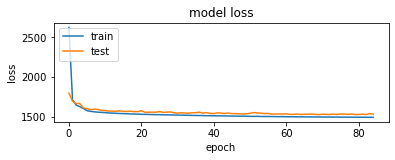

Train on 50000 samples, validate on 10000 samples
Epoch 1/500
50000/50000 [==============================] - 59s 1ms/step - loss: 2543.7787 - val_loss: 1703.3286
Epoch 2/500
50000/50000 [==============================] - 61s 1ms/step - loss: 1616.5141 - val_loss: 1602.5838
Epoch 3/500
50000/50000 [==============================] - 58s 1ms/step - loss: 1554.7334 - val_loss: 1562.9775
Epoch 4/500
50000/50000 [==============================] - 61s 1ms/step - loss: 1536.0058 - val_loss: 1553.9647
Epoch 5/500
50000/50000 [==============================] - 59s 1ms/step - loss: 1517.0772 - val_loss: 1519.7928
Epoch 6/500
50000/50000 [==============================] - 60s 1ms/step - loss: 1500.0224 - val_loss: 1530.1517
Epoch 7/500
50000/50000 [==============================] - 61s 1ms/step - loss: 1493.3315 - val_loss: 1544.6282
Epoch 8/500
50000/50000 [==============================] - 61s 1ms/step - loss: 1488.2920 - val_loss: 1522.7971
Epoch 9/500
50000/50000 [=============================

50000/50000 [==============================] - 53s 1ms/step - loss: 1434.3500 - val_loss: 1463.8702
Epoch 74/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1434.2893 - val_loss: 1464.4593
Epoch 75/500
50000/50000 [==============================] - 53s 1ms/step - loss: 1434.4022 - val_loss: 1465.8832
Epoch 76/500
50000/50000 [==============================] - 53s 1ms/step - loss: 1433.4642 - val_loss: 1466.2589
Epoch 77/500
50000/50000 [==============================] - 53s 1ms/step - loss: 1434.2025 - val_loss: 1464.2048
Epoch 78/500
50000/50000 [==============================] - 57s 1ms/step - loss: 1433.5947 - val_loss: 1471.5601
Epoch 79/500
50000/50000 [==============================] - 59s 1ms/step - loss: 1433.3741 - val_loss: 1467.1820
Epoch 80/500
50000/50000 [==============================] - 61s 1ms/step - loss: 1432.4154 - val_loss: 1463.9778
Epoch 81/500
50000/50000 [==============================] - 60s 1ms/step - loss: 1433.2460 - val_loss: 1464.0

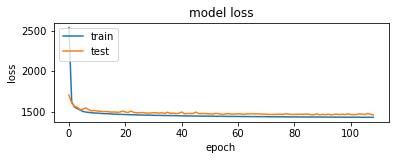

Train on 50000 samples, validate on 10000 samples
Epoch 1/500
50000/50000 [==============================] - 54s 1ms/step - loss: 2651.1596 - val_loss: 1792.9340
Epoch 2/500
50000/50000 [==============================] - 54s 1ms/step - loss: 1698.3587 - val_loss: 1688.4410
Epoch 3/500
50000/50000 [==============================] - 53s 1ms/step - loss: 1629.8179 - val_loss: 1629.1644
Epoch 4/500
50000/50000 [==============================] - 53s 1ms/step - loss: 1584.2966 - val_loss: 1602.3378
Epoch 5/500
50000/50000 [==============================] - 53s 1ms/step - loss: 1568.9109 - val_loss: 1594.8746
Epoch 6/500
50000/50000 [==============================] - 53s 1ms/step - loss: 1558.4470 - val_loss: 1573.4672
Epoch 7/500
50000/50000 [==============================] - 53s 1ms/step - loss: 1538.7204 - val_loss: 1561.7829
Epoch 8/500
50000/50000 [==============================] - 53s 1ms/step - loss: 1530.7445 - val_loss: 1551.4638
Epoch 9/500
50000/50000 [=============================

50000/50000 [==============================] - 104s 2ms/step - loss: 1444.1621 - val_loss: 1473.5594
Epoch 73/500
50000/50000 [==============================] - 105s 2ms/step - loss: 1442.7796 - val_loss: 1470.0485
Epoch 74/500
50000/50000 [==============================] - 105s 2ms/step - loss: 1443.4508 - val_loss: 1473.6435
Epoch 75/500
50000/50000 [==============================] - 107s 2ms/step - loss: 1442.3464 - val_loss: 1471.3338
Epoch 76/500
50000/50000 [==============================] - 109s 2ms/step - loss: 1443.2020 - val_loss: 1470.8480
Epoch 77/500
50000/50000 [==============================] - 88s 2ms/step - loss: 1443.4034 - val_loss: 1472.5834
Epoch 78/500
50000/50000 [==============================] - 74s 1ms/step - loss: 1443.6818 - val_loss: 1474.2086
Epoch 79/500
50000/50000 [==============================] - 81s 2ms/step - loss: 1441.7617 - val_loss: 1468.9962
Epoch 80/500
50000/50000 [==============================] - 79s 2ms/step - loss: 1440.7951 - val_loss: 1

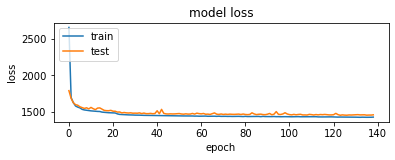

Train on 50000 samples, validate on 10000 samples
Epoch 1/500
50000/50000 [==============================] - 57s 1ms/step - loss: 2795.2541 - val_loss: 1861.3834
Epoch 2/500
50000/50000 [==============================] - 55s 1ms/step - loss: 1713.3753 - val_loss: 1693.3213
Epoch 3/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1632.5563 - val_loss: 1665.8006
Epoch 4/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1610.2520 - val_loss: 1625.4861
Epoch 5/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1595.7219 - val_loss: 1614.3661
Epoch 6/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1566.5795 - val_loss: 1588.5247
Epoch 7/500
50000/50000 [==============================] - 55s 1ms/step - loss: 1553.2104 - val_loss: 1586.2087
Epoch 8/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1545.6888 - val_loss: 1568.7650
Epoch 9/500
50000/50000 [=============================

C:\Users\PazderaAaron\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.232469). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


50000/50000 [==============================] - 56s 1ms/step - loss: 1490.2286 - val_loss: 1515.6649
Epoch 27/500
50000/50000 [==============================] - 55s 1ms/step - loss: 1489.1733 - val_loss: 1518.1329
Epoch 28/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1488.4406 - val_loss: 1514.0714
Epoch 29/500
50000/50000 [==============================] - 55s 1ms/step - loss: 1487.0350 - val_loss: 1519.5809
Epoch 30/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1486.6785 - val_loss: 1511.4028
Epoch 31/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1486.0084 - val_loss: 1515.3053
Epoch 32/500
50000/50000 [==============================] - 55s 1ms/step - loss: 1484.5034 - val_loss: 1518.5564
Epoch 33/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1484.8410 - val_loss: 1514.2857
Epoch 34/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1484.1485 - val_loss: 1513.8

50000/50000 [==============================] - 63s 1ms/step - loss: 1466.9939 - val_loss: 1498.7957
Epoch 99/500
50000/50000 [==============================] - 64s 1ms/step - loss: 1466.3737 - val_loss: 1504.0868
Epoch 100/500
50000/50000 [==============================] - 62s 1ms/step - loss: 1466.9110 - val_loss: 1495.3136
Epoch 101/500
50000/50000 [==============================] - 65s 1ms/step - loss: 1465.5958 - val_loss: 1495.9878
Epoch 102/500
50000/50000 [==============================] - 63s 1ms/step - loss: 1465.5199 - val_loss: 1501.2630
Epoch 103/500
50000/50000 [==============================] - 65s 1ms/step - loss: 1466.0977 - val_loss: 1494.8592
Epoch 104/500
50000/50000 [==============================] - 64s 1ms/step - loss: 1465.9022 - val_loss: 1510.0243
Epoch 105/500
50000/50000 [==============================] - 59s 1ms/step - loss: 1465.2759 - val_loss: 1500.8817
Epoch 106/500
50000/50000 [==============================] - 60s 1ms/step - loss: 1465.3854 - val_loss:

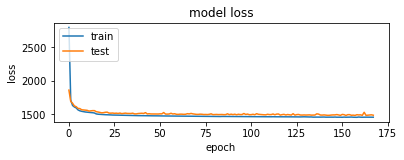

Train on 50000 samples, validate on 10000 samples
Epoch 1/500
50000/50000 [==============================] - 56s 1ms/step - loss: 2485.9546 - val_loss: 1805.2025
Epoch 2/500
50000/50000 [==============================] - 55s 1ms/step - loss: 1725.2993 - val_loss: 1720.5167
Epoch 3/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1678.9259 - val_loss: 1691.6566
Epoch 4/500
50000/50000 [==============================] - 55s 1ms/step - loss: 1660.4014 - val_loss: 1702.2592
Epoch 5/500
50000/50000 [==============================] - 55s 1ms/step - loss: 1631.5026 - val_loss: 1637.6178
Epoch 6/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1602.3020 - val_loss: 1616.5614
Epoch 7/500
50000/50000 [==============================] - 55s 1ms/step - loss: 1573.8206 - val_loss: 1603.1049
Epoch 8/500
50000/50000 [==============================] - 56s 1ms/step - loss: 1567.5642 - val_loss: 1595.6581
Epoch 9/500
50000/50000 [=============================

In [ ]:
if train_ed:
    # Train some models, save the good ones.
    # The feilds in the file name are as follows:
    best_loss = np.Infinity
    for i in range(num_models):
        # Because weights cannot be reset, the model must be rebuilt every time we want to 
        # train a new one. But, luckily, it's not that bad.
        encode_decode = build_encode_decode(i_shape, latent_shape, convlayers, denselayers)
        encode_decode.compile(optimizer='adam', loss=mean_squared_error)
        
        # Train the model
        history = encode_decode.fit(x_train, x_train, \
                        validation_data=(x_test, x_test), \
                        validation_split=validation_ratio, \
                        epochs=epoch_num, batch_size=batch_size, shuffle=True, \
                        callbacks=callbacks)
    
        # Evaluate how well we've done
        loss_score = min(history.history['val_loss'])
        best_epoch = history.history['val_loss'].index(loss_score)
    
        # Require the model to train for more than 10 epochs, and save it if it's good.
        if 10 < best_epoch and best_loss >= loss_score:
            best_loss = loss_score
            os.makedirs('models/encode-decode', exist_ok=True)
            rand = ''.join(random.choices("0123456789", k=10))
            fname = f'models/encode-decode/{int(loss_score)}_{side_length}_{latent_shape[1]}_{convlayers}_{denselayers}_{distance_weight}_{mse_weight}_{rand}.h5' 
            encode_decode.save(fname)
            print(f'Saving model: {fname}')
        
        # Print 
        print(f'Best Epoch: {best_epoch}')
        print(f'Current Loss: {loss_score}')
        print(f'Best Loss: {best_loss}')
        plot_loss(history)

# Load the Encode-Decode Model

In [ ]:
def load_ed_model():
    # Find the best one
    best_split = ''
    for root, dirs, files in os.walk("models/encode-decode", topdown=False):
        for name in files:
            spt = name.split('_')
            spt[7] = spt[7][:-3]
            nloss = spt[0]
            nsidelength = spt[1]
            nlatent = spt[2]
            nconv = spt[3]
            ndense = spt[4]
            ndistw = spt[5]
            nmsew = spt[6]
            nrand = spt[7]
            if (int(nsidelength) == side_length) and (int(nlatent) == latent_shape[1]) and (int(nconv) == convlayers) and \
        (int(ndense) == denselayers) and (int(ndistw) == distance_weight) and (int(nmsew) == mse_weight):
                best_split = spt
    # Load the best one
    best = 'models/encode-decode/' + '_'.join(best_split) + '.h5'
    print(f'loaded model: {best}')
    return load_model(best) if best_split != '' else None

def get_ed_model():
    try:
        global encode_decode
        encode_decode
    except NameError:
        encode_decode = load_ed_model()
    return encode_decode

encode_decode = load_ed_model()

In [ ]:
# Now let's define some functions, then try the model out.
def download_img(img_url):
    return Image.open(urlopen(img_url))

def resize_img(img):
    convd_img = img.resize((side_length, side_length))
    convd_img = convd_img.convert('RGB')
    return convd_img

def run_ed_model(img):
    img_array = np.asarray(img)
    img_array = img_array.reshape((1, side_length, side_length, 3))
    decoded_tensor = get_ed_model().predict(img_array).reshape((side_length, side_length, 3))
    nd = tf.make_ndarray(tf.make_tensor_proto(decoded_tensor))
    return nd.astype(int)

def get_encoder():
    return get_ed_model().get_layer('Encode')

def get_decoder():
    return get_ed_model().get_layer('Encode')

def run_encoder(img):
    img_array = np.asarray(img)
    img_array = img_array.reshape((1, side_length, side_length, 3))
    encoder = get_encoder()
    newshape = list(latent_shape)
    newshape[0] = 1
    encoded_tensor = encoder.predict(img_array).reshape(newshape)
    return tuple(encoded_tensor[0])

def show_images(img_url, show=False):
    # Download image and convert.
    original_img = download_img(img_url)
    convd_img = resize_img(original_img)
    
    # Show original image and resized image.
    plt.axis('off')
    plt.subplot(1, 3, 1).title.set_text('original')
    plt.imshow(original_img)
    plt.subplot(1, 3, 2).title.set_text('input to model')
    plt.imshow(convd_img)
    plt.subplot(1, 3, 3).title.set_text('output from model')
    output = run_ed_model(convd_img)
    plt.imshow(output)
    plt.show()
    latent = run_encoder(convd_img)
    print(f'Latent space: {latent}')
    return latent

l1 = show_images('https://i.redd.it/dchg4s8j485z.png')
print('As the encoder wasn\'t trained on a dataset of illustrations, it didn\'t get to see many, if any images with solid backgrounds. We can expect this to improve with a larger latent space.')
l2 = show_images('https://safebooru.org//samples/2886/sample_69950b7fd527da6e598cb65c244621e0010641af.jpg?3006072')
print(f'Distance: {np.linalg.norm(np.asarray(l1)-np.asarray(l2))}')

## Discussion of results with output shape (None, 4) and an unrelated dataset

As you can see if you set the input shape to (32, 32) and the output to (None, 4) trained on the cifar100 dataset, the results appear kinda awful. Or, That's what you would think.

However, with output shape of only 4 floating point numbers, this isn't actually that bad. In fact, I'd say that it's about as good as you can get. It more just for me, showed that you can optimize the model for what you want it to accomplish.

As they say, storage is cheap, but if you care about having a smaller hashes, you can use less principle components. This was a test, because phash is 64 bits long. Four floating point numbers, 128 bits is not much at all to compress an image down to.

The objective here is not to reconstruct the image. The objective is to find images that are close. And this might not quite get you there, but it might actually get you partway.

In practical implementation of a near-duplicate matching database, you're going to consume more, or orders of magnitude more space storing images or filepath/url references to images. In that way, you could justify larger output shapes.

We have reason to believe that a larger output space will improve the quality of the model. What's pictured above won't work. The big questions now is how do large do we want the output space, how large do we want the input space, how many convolutional layers should there be, and by how much does the model improve when we change these things.

![image](32_to_4_result.png)
<center><b>Latent space: [195.22295  159.0578   153.84795  104.884476]</b></center>

<br><br>
<center>The model was actually trained on images like the ones here:<center>
<img src="https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fcorochann.com%2Fwp-content%2Fuploads%2F2017%2F04%2Fcifar10_plot_more.png&f=1&nofb=1" width=500, height=500, alt="cifar100 real-world picture dataset examples">
<br><br>
<center>We should expect some degree of improvement when trained on illustrations, especially on images with solid backgrounds.</center>

# Full Model

In [ ]:
# combined_input_layer will branch automatically.
combined_input_layer = Input(shape=i_shape, name='Full_Model_Input')
noised_input = GaussianNoise(0.1, name='Noise')(combined_input_layer)

# Compress input and noised input to latent space, and hold on to a reference.
encoder = get_encoder()
decoder = get_decoder()
vec1 = encoder(combined_input_layer)
vec2 = encoder(noised_input)

# Decode the original image from the latent space
unencoded_original = decoder(vec1)

combined_model = Model( \
    inputs=combined_input_layer, \
    outputs=[vec1, vec2, combined_input_layer, unencoded_original])

# Define Loss, Complile Full Model

In [ ]:
# TODO figure out how to define loss like this without requiring the model to 
# output the second latent space, the input, or the decoded image.

# y_true is what is passed to the fit() method, which we aren't actually using.
# Those quantities will be unknown, this is unsupervised.
# y_pred is the output of the model.
def total_loss(y_true, y_pred):
    dist = (K.sqrt(K.sum(K.square(y_pred[0] - y_pred[1]), axis=-1)))
    mse = (K.mean(K.square(y_pred[2] - y_pred[3]), axis=-1))
    return (distance_weight*dist) + (mse_weight*mse) # Weights were defined at the beginning

combined_model.compile(optimizer='adam', loss=total_loss)
print(combined_model.summary())

In [ ]:
# Here's the spot where I was having issues.
train_full = True
if train_full:
    combined_model.fit(x_train, None, 
                        validation_data=(x_test, x_test), 
                        validation_split=0.25, # This is redundant, for when I strip away the seperate validation set. 
                        epochs=epoch_num, batch_size=batch_size, shuffle=True, 
                        callbacks=callbacks)
    
# Indeed, it is a shape problem. Specidically, with the validation data. It's supposed to match up with
# the shape of the output. However, I figure that there must be some way to train on things without having
# to also output them. The only "output" that I'm really interested in using is vec1. Although I'll be stripping
# away everything but the encoder, I feel like it would be good to know.